# <font color=#531AC8>Fatoração de Matrizes para Sistemas de Classificação de Machine Learning</font>
> __Trabalho para a disciplina CCM0218 (2020.2)__ <br>
Fernando Valls Yoshida (11246714) e Lucas de Sousa Rosa (11296717)

Para a realização deste trabalho, nos reunimos periodicamente para ler o material fornecido, acompanhando as passagens e discutindo os pseudo-códigos. Enquanto isso, foi elaborado este Jupyter Notebook, em que constam os códigos que escrevemos, as considerações sobre eles e o relatório das tarefas exigidas. Na ordem natural em que aparecem no texto fornecido, os temas abordados virão neste documento. Além deste documento, entregamos também arquivos `.py` com uma versão executável dos métodos aqui apresentados, de forma mais amistosa à checagem de seu funcionamento e/ou consulta do código.<br>
<br>
O presente documento divide-se em 4 seções principais: __Primeira Tarefa__, que conta com explicações de posições adotadas para a escrita dos métodos, estes que também encontram-se na seção, e os testes sugeridos; __Segunda tarefa__, idem; __Tarefa Principal__, em que consta não somente os códigos concernentes a esta seção, mas também a visualização e discussão de alguns dados e a apresentação de gráficos que articulam e refletem a respeito dos resultados obtidos; e o __Apêndice__, que conta com a proposição de testes de checagem de funcionamento para cada um dos testes, além de resultados de cálculos feitos a partir de `Octave`, com a mesma finalidade de checagem.

__Seção para importação das bibliotecas__

In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import time
from datetime import datetime
import re

## <font color=#C8531A>Primeira tarefa</font>

> Observação: em Álgebra Linear, é natural contar as posições de matrizes começando em 1, mas Numpy o faz começando em 0. Em face disso, aqui optou-se por manter a contagem da Álgebra sempre que possível. Em caso contrário, são feitas intervenções diretas no sistema de contagem, ou como ajuste geral (fazendo, e.g., $i = i - 1$ no início de um trecho de código) ou como ajuste de indexação no uso de um elemento da matriz (e.g., $W[i - 1, j - 1]$ para fazer $W_{i,j}$). Sempre que conveniente, tais medidas são apontadas no corpo do código.

A primeira tarefa trata da __resolução de sistemas lineares através da Fatoração QR__, em caso de sistemas sobredeterminados, individual (`solve`) e simultaneamente (`solve_multi`). Para ambos os casos, faz-se necessário implementar uma rotação de Givens $Q(i,j,\theta)$ (`rot_Givens`) que, por sua vez, depende de uma implementação de `cos_sin`, definido tal como no documento de referência.<br>
Estes quatro métodos encontram-se abaixo. As verificações de funcionamento de todos os métodos estão no __Apêndice__ deste documento.

__Determina os valores de cos(θ) e sin(θ), conforme (3) e (4)__

In [4]:
def cos_sin(W, i, j, k):
    # ajuste de contagem
    i = i - 1
    j = j - 1
    k = k - 1
    
    if abs(W[i,k]) > abs(W[j,k]):
        t = -W[j,k]/W[i,k]
        c = 1/math.sqrt(1 + t**2)
        s = c*t
    else:
        t = -W[i, k]/W[j, k]
        s = 1/math.sqrt(1 + t**2)
        c = s*t    
    return c, s

__Rotação de Givens Q(i, j, θ) a ser aplicada em $W_{n \times m}$__

In [5]:
def rot_Givens(W, n, m, i, j, c, s):
    # ajuste de contagem
    i = i - 1
    j = j - 1

    W[i,0:m], W[j,0:m] = c*W[i,0:m] - s*W[j,0:m], s*W[i,0:m] + c*W[j,0:m]

> Observação: Para `solve` e `solve_multi` há a construção de uma matriz resposta, que poderia ser retornada por cada um destes métodos. Porém, em se tratando tipicamente de matrizes de dimensões elevadas, optou-se neste projeto por sobrescrever estes valores resultado na matriz da direita (a matriz $b$, em um sistema $W \cdot x = b$). Para isto, faz-se necessário mostrar que:<br>
(i) os valores para a definição de um elemento em $x$ não dependem de elementos anteriores em $b$ (que, sobrescritos, estariam perdidos) e<br>
(ii) a definição de $x_{j}$ não pode depender de valores de $x_{i}$, se, na ordem em que se avança o cálculo, j precede i (i.e., não se pode usar um elemento ainda não calculado).<br>
<br>
>No caso de `solve`, nota-se que, para<br>
$x_{k} = \left( b_{k} - \sum_{j=k+1}^{m}w_{k,j}x_{j} \right)/w_{k,k}$<br>
o valor de $b_{k}$ é usado uma única vez, e somente para a definição de $x_{k}$. Ainda, para a definição deste, usa-se $x_{j}$, com $m \leq j \leq k+1$ (e $k$ progride de $m$ a 1, logo estes são valores anteriores a $k$). É por este motivo, na linha do que inicialmente argumentado, que se pode sobrescrever $x$ em $b$.<br>
Analogamente, para `solve_multi` (um sistema $W \cdot H = A$), em que há<br>
$h_{k,j} = \left( a_{k,j} - \sum_{i=k+1}^{p}w_{k,i}h_{i,j} \right)/w_{k,k}$<br>
o valor $a_{k,j}$ é usado somente para a definição de $h_{k,j}$, tendo ainda que os $h_{i,j}$ usados têm $k+1 \leq i \leq p$ (e $k$ progride de $p$ a 1, logo estes valores de $i$ correspondem aos termos $k$ anteriores, já calculados) e $j$ é o mesmo do elemento calculado no momento ($h_{k,j}$). De maneira análoga, portanto, justifica-se a sobrescrita.<br>
<br>
Cabe ainda considerar que não necessariamente a matriz resultado e a matriz direita possuem as mesmas dimensões, motivo pelo qual, em um sistema genérico $W \cdot x = b$, a matriz $b$ sobrescrita possui os valores de $x$ somente nas posições em que se define $x$ e o demais valores não são de interesse. Esta consideração se manifesta doravante na seleção de trechos de $b$ para definir $x$ (e.g., se $x_{3 \times 1}$ se define a partir de $b_{5 \times 1}$, representa-se, no corpo do código, $x$ como `b[:4,:]`.

__Resolução de sistemas sobredeterminados__

In [6]:
def solve(W, b, n, m):
    eps = 10e-10       # zero
    for k in range(1, m + 1):
        for j in range(n, k, -1):
            i = j - 1
            if abs(W[j - 1, k - 1]) > eps:
                cos, sin = cos_sin(W, i, j, k)
                rot_Givens(W, n, m, i, j, cos, sin)
                rot_Givens(b, n, 1, i, j, cos, sin)
    
    for k in range(m, 0, -1):
        soma = 0
        for j in range(k + 1, m + 1):
            soma += W[k - 1, j - 1]*b[j - 1, 0]
        b[k - 1, 0] = (b[k - 1, 0] - soma)/W[k - 1, k - 1]

__Vários sistemas simultâneos__

In [7]:
def solve_multi(W, A, n, m, p):
    eps = 10e-10       # zero
    for k in range(1, p + 1):
        for j in range(n, k, -1):
            i = j - 1
            if abs(W[j - 1, k - 1]) > eps:
                cos, sin = cos_sin(W, i, j, k)
                rot_Givens(W, n, p, i, j, cos, sin)
                rot_Givens(A, n, m, i, j, cos, sin)
    
    for k in range(p, 0, -1):
        for j in range(1, m + 1):
            soma = 0
            for i in range(k+1,p+1):
                soma += W[k-1,i-1]*A[i-1,j-1]
            A[k-1,j-1] = (A[k-1,j-1] - soma)/W[k-1,k-1]

## Testes sugeridos

Dispõem-se abaixo os métodos associados à resolução de cada um dos testes sugeridos, que, por um lado, montam as matrizes-teste e, por outro, solucionam o sistema com os métodos já construídos na __Primeira Tarefa__. Para cada um dos testes, fez-se a devida verificação dos resultados com o `Octave` e estes dados encontram-se no __Apêndice__ deste documento.

In [8]:
def teste_a():
    n = 64
    m = 64
    W = np.zeros((n,m))
    b = np.zeros((n,1))
    for i in range(1, n+1):
        for j in range(1, m+1):
            if i == j:
                W[i - 1, j - 1] = 2
            elif abs(i - j) == 1:
                W[i - 1, j - 1] = 1
            elif abs(i - j) > 1:
                W[i - 1, j - 1] = 0
            b[i - 1, 0] = 1
    solve(W,b,n,m)
    print(b)
teste_a()

[[0.49230769]
 [0.01538462]
 [0.47692308]
 [0.03076923]
 [0.46153846]
 [0.04615385]
 [0.44615385]
 [0.06153846]
 [0.43076923]
 [0.07692308]
 [0.41538462]
 [0.09230769]
 [0.4       ]
 [0.10769231]
 [0.38461538]
 [0.12307692]
 [0.36923077]
 [0.13846154]
 [0.35384615]
 [0.15384615]
 [0.33846154]
 [0.16923077]
 [0.32307692]
 [0.18461538]
 [0.30769231]
 [0.2       ]
 [0.29230769]
 [0.21538462]
 [0.27692308]
 [0.23076923]
 [0.26153846]
 [0.24615385]
 [0.24615385]
 [0.26153846]
 [0.23076923]
 [0.27692308]
 [0.21538462]
 [0.29230769]
 [0.2       ]
 [0.30769231]
 [0.18461538]
 [0.32307692]
 [0.16923077]
 [0.33846154]
 [0.15384615]
 [0.35384615]
 [0.13846154]
 [0.36923077]
 [0.12307692]
 [0.38461538]
 [0.10769231]
 [0.4       ]
 [0.09230769]
 [0.41538462]
 [0.07692308]
 [0.43076923]
 [0.06153846]
 [0.44615385]
 [0.04615385]
 [0.46153846]
 [0.03076923]
 [0.47692308]
 [0.01538462]
 [0.49230769]]


In [9]:
def teste_b():
    n = 20
    m = 17
    W = np.zeros((n,m))
    b = np.zeros((n,1))
    for i in range(1,n+1):
        for j in range(1,m+1):
            if abs(i - j) <= 4:
                W[i - 1, j - 1] = 1.0/(i + j - 1)
            elif abs(i - j) > 4:
                W[i - 1, j - 1] = 0
        b[i - 1, 0] = i
    solve(W, b, n, m)
    print(b[0:m,:])
teste_b()

[[ 56.35780802]
 [-45.87484885]
 [-43.48902374]
 [-48.5765491 ]
 [-30.14020001]
 [ 89.81211894]
 [ 48.713648  ]
 [ 59.23924714]
 [ 11.44635697]
 [109.16273559]
 [-72.87275483]
 [-54.36289269]
 [-51.44441718]
 [-25.01481463]
 [ 98.57193882]
 [218.65885869]
 [298.40022751]]


In [10]:
def teste_c():
    n = 64
    m = 3
    p = 64
    W = np.zeros((n,p))
    A = np.zeros((n,m))
    for i in range(1,n+1):
        for j in range(1, p+1):
            if abs(i - j) == 1:
                W[i - 1, j - 1] = 1
            elif abs(i - j) > 1:
                W[i - 1, j - 1] = 0
        A[i - 1, 0] = 1
        A[i - 1, 1] = i
        A[i - 1, 2] = 2*i
    solve_multi(W,A,n,m,p)
    print(A)
teste_c()

[[ -0. -32. -64.]
 [  1.   1.   2.]
 [  1.  34.  68.]
 [ -0.   2.   4.]
 [ -0. -30. -60.]
 [  1.   3.   6.]
 [  1.  36.  72.]
 [ -0.   4.   8.]
 [ -0. -28. -56.]
 [  1.   5.  10.]
 [  1.  38.  76.]
 [ -0.   6.  12.]
 [ -0. -26. -52.]
 [  1.   7.  14.]
 [  1.  40.  80.]
 [ -0.   8.  16.]
 [ -0. -24. -48.]
 [  1.   9.  18.]
 [  1.  42.  84.]
 [ -0.  10.  20.]
 [ -0. -22. -44.]
 [  1.  11.  22.]
 [  1.  44.  88.]
 [ -0.  12.  24.]
 [ -0. -20. -40.]
 [  1.  13.  26.]
 [  1.  46.  92.]
 [ -0.  14.  28.]
 [ -0. -18. -36.]
 [  1.  15.  30.]
 [  1.  48.  96.]
 [ -0.  16.  32.]
 [ -0. -16. -32.]
 [  1.  17.  34.]
 [  1.  50. 100.]
 [ -0.  18.  36.]
 [ -0. -14. -28.]
 [  1.  19.  38.]
 [  1.  52. 104.]
 [ -0.  20.  40.]
 [ -0. -12. -24.]
 [  1.  21.  42.]
 [  1.  54. 108.]
 [ -0.  22.  44.]
 [ -0. -10. -20.]
 [  1.  23.  46.]
 [  1.  56. 112.]
 [ -0.  24.  48.]
 [ -0.  -8. -16.]
 [  1.  25.  50.]
 [  1.  58. 116.]
 [ -0.  26.  52.]
 [ -0.  -6. -12.]
 [  1.  27.  54.]
 [  1.  60. 120.]
 [ -0.  28

In [11]:
def teste_d():
    n = 20
    m = 3
    p = 17
    W = np.zeros((n,p))
    A = np.zeros((n,m))
    for i in range(1,n+1):
        for j in range(1,p+1):
            if abs(i - j) <= 4:
                W[i - 1, j - 1] = 1.0/(i + j - 1)
            elif abs(i - j) > 4:
                W[i - 1, j - 1] = 0
        A[i - 1, 0] = 1
        A[i - 1, 1] = i
        A[i - 1, 2] = 2*i
    solve_multi(W,A,n,m,p)
    print(A[0:p,:])
teste_d()

[[ 2.88155063e+00  5.63578080e+01  1.12715616e+02]
 [-1.83376253e+00 -4.58748489e+01 -9.17496977e+01]
 [-1.51398904e+00 -4.34890237e+01 -8.69780475e+01]
 [-1.52190762e+00 -4.85765491e+01 -9.71530982e+01]
 [-4.53794614e-01 -3.01402000e+01 -6.02804000e+01]
 [ 5.85669889e+00  8.98121189e+01  1.79624238e+02]
 [ 3.42192891e+00  4.87136480e+01  9.74272960e+01]
 [ 3.65656219e+00  5.92392471e+01  1.18478494e+02]
 [ 1.20368454e+00  1.14463570e+01  2.28927139e+01]
 [ 6.12534249e+00  1.09162736e+02  2.18325471e+02]
 [-2.47971396e+00 -7.28727548e+01 -1.45745510e+02]
 [-1.47793147e+00 -5.43628927e+01 -1.08725785e+02]
 [-1.20390258e+00 -5.14444172e+01 -1.02888834e+02]
 [ 1.28414690e-01 -2.50148146e+01 -5.00296293e+01]
 [ 6.50158900e+00  9.85719388e+01  1.97143878e+02]
 [ 1.14910560e+01  2.18658859e+02  4.37317717e+02]
 [ 1.45805258e+01  2.98400228e+02  5.96800455e+02]]


## <font color=#C8531A>Segunda tarefa</font>

A segunda tarefa trata da __fatoração por matrizes não-negativas__, que está implementado em `NMF`, este que depende de alguns métodos auxiliares: para o cálculo do erro (`erro`), para a normalização das matrizes (`norm`) e ainda para recortar uma matriz (como os cálculos são feitos reescrevendo por cima da matriz inicial, nas vezes em que se faz necessário individulizar essa matriz, é preciso "criá-la" de novo) e ainda zerar os elementos negativos, no sentido em que abordado no documento (`set_matrix`).

__Determina o erro quadrático $E = \| A - WH  \|^2 $__

In [12]:
def erro(A,W,H,n,m):
    E = 0
    prod = W.dot(H)
    for i in range(1,n+1):
        for j in range(1,m+1):
            E += (A[i-1,j-1] - prod[i-1,j-1])**2
    return E

__Normaliza $W_{n \times p}$ de tal modo que $w_{i,j} = \frac{w_{i,j}}{s_{j}}$, com $s_{j} = \sqrt{\sum_{i=1}^{n}w_{i,j}^2}$__

In [13]:
def norm(W,n,p):
    for j in range(1,p+1):
        s = 0
        for i in range(1,n+1):
            s += (W[i-1,j-1])**2
        s = math.sqrt(s)
        W[0:n,j-1] = W[0:n,j-1]/s
    return W

__Define $B_{p \times m}$ a partir de $A_{n \times m}$. B é definido a partir da porção superior (p primeiras linhas e todas as m colunas) de A, sendo ainda que $b_{i,j} = a_{i,j}$, se e somente se $a_{i,j} \geq 0$, do contrário $b_{i,j} = 0$__

In [14]:
def set_matrix(A,p,m):
    B = np.zeros((p,m))
    for i in range(1,p+1):
        for j in range(1,m+1):
            if A[i-1,j-1] > 0:
                B[i-1,j-1] = A[i-1,j-1]
    return B

__Fatoração por matrizes não-negativas__

> Observação: De modo a calcular a diferença entre erros de iterações sucessivas, adotou-se uma estratégia de "erros alternados". Convencionou-se que em interações ímpares o erro é guardado na variável $e_{1}$, e em interações pares em $e_{2}$. Assim, trivialmente, a diferença de erros entre iterações sucessivas dá-se por $|e_{1} - e_{2}|$.

In [15]:
def NMF(A,n,m,p):
    # parâmetros
    eps = 10e-5
    it_max = 100
    # inicialização de variáveis de apoio
    e1 = 0
    e2 = 0
    t = 0
    # inicialização/setagem das matrizes de interesse
    W = np.random.rand(n,p)
    A_copia = np.copy(A)
    At_copia = np.copy(np.transpose(A))
    H = np.zeros((p,m))
    
    while(t < it_max):
        if (t > 1 and abs(e1 - e2) < eps):
            break
    
        A = np.copy(A_copia)              # recuperar A original
        W = norm(W,n,p)                   # normalizar W
        solve_multi(W, A, n, m, p)        # WH = A
        H = set_matrix(A,p,m)             # H a partir de A

        At = np.copy(At_copia)            # computar A^t
        Ht = np.copy(np.transpose(H))     # computar H^t
        solve_multi(Ht, At, m, n, p)      # (WH)^t = H^tW^t = A^t
        Wt = set_matrix(At, p, n)         # W^t a partir de A^t
        W = np.copy(np.transpose(Wt))     # computar W (a partir de W^t)
        
        if t % 2 != 0:                    # erro em iteração ímpar
            e1 = erro(A_copia, W, H, n, m)
        else:                             # erro em iteração par
            e2 = erro(A_copia, W, H, n, m)
        
        t += 1
    return W, H

## <font color=#C8531A>Tarefa principal</font>

A __Tarefa principal__ consiste em duas atividades principais: o preparo dos treinos $W_{d}$ que, a partir do banco de dados com uma série de exemplares de dígitos, representa um "dígito platônico", a ideia de um tal dígito que se abstrai da materialidade dos exemplos dados; e, finalmente, a proposição de um palpite para as imagens dadas, tentar identificar qual dígito cada imagem representa, a partir daquela que apresentar o menor erro em relação a um processamento dos $W_{d}$ via MMQ.<br>
<br>
Nesse sentido, são duas as variáveis de interesse: $n_{dig}$ e $p$, que representam, respectivamente, quantos dos dígitos do banco de dados serão usados para a construção de $W_{d}$, e quantas formas platônicas serão montadas. Inicialmente, o interesse residirá principalmente em avaliar como a variação desses parâmetros impacta na taxa de acerto dos palpites; depois, será feita uma análise qualitativa a respeito de cada um dos dígitos, seguida de uma confirmação quantitativa.

### <font color=#C81A38>Treinamentos dos dígitos $W_{d}$</font>

__Cria um $W_{d}$ específico__

In [16]:
def train_dig(digito, ndig_treino, p):
    n = 784
    A = np.loadtxt("dados_mnist/train_dig" + str(digito) + ".txt")
    A = A[:,:ndig_treino]
    m = ndig_treino
    Wd, H = NMF(A,n,m,p)
    return Wd

__Cria todos os treinos $W_{d}$ para todos os $n_{dig}$ e $p$ propostos, salva-os em arquivos de texto, considerando o tempo gasto para cada treino__

In [15]:
def train_all():
    ndig_treino = [100,1000,4000]
    ps = [5,10,15]

    for ndig in ndig_treino:
        for p in ps:
            for digito in range(10):
                start = time.time()
                Wd = train_dig(digito, ndig, p)
                elapsed_time_lc = (time.time() - start)
                filename = "dig_treino/W_" + str(digito) + "_" + str(ndig) + "_" + str(p) + ".txt" 
                with open(filename, "w+") as f:
                    f.write(str(elapsed_time_lc) + "\n")
                    np.savetxt(f, Wd)
train_all()

### <font color=#C81A38>Tempos relativos à `train_all`</font>

A execução de `train_all` gera todos os 90 treinos (todas as combinações de 3 tipos de $n_{dig}$ com os 3 tipos de $p$, para todos os 10 dígitos), em forma de um arquivo de texto. Para avaliar a performance do algoritmo como um todo, fez-se o método `time_train` que apresenta os tempos de execução (que já são contatos em `train_all`), suas médias e parâmetros de "resposta" da variação do tempo à variação de um desses parâmetros (matematicamente, é uma média da razão de razões). Apresenta-se a seguir este método, seguido depois de um comentário.

__Organiza e apresenta os tempos relativos à execução de `train_all`__

In [17]:
def time_train():
    T = np.zeros((9,11))
    ndigs = [100,1000,4000]
    ps = [5,10,15]
    
    # Recolher tempos
    t = 0
    soma = 0
    total = 0
    for ndig in ndigs:
        for p in ps:
            for dig in range(10):
                with open("dig_treino/W_{}_{}_{}.txt".format(dig,ndig,p)) as file:
                    T[t,dig] = float(file.readline())
                    soma += T[t, dig]
            total += soma
            T[t,10] = soma/10
            soma = 0
            t += 1
    t += 1
    
    # Apresentar os tempos
    print("Tabela dos tempos")
    print("".ljust(110,"*"))
    print("ndig_p  |      0        1        2        3        4        5        6        7        8        9      média")
    print("".ljust(110,"*"))

    for i in range(9):
        print(("{}_{}".format(ndigs[i // 3],ps[i % 3])).ljust(8," "),end = "|    ")
        for j in range(11):
            mins = int((T[i,j] % 3600) // 60)
            secs = int(T[i,j] % 60)                
            print("{}m{}s".format(mins,secs).ljust(9," "), end = "")
        print("\n")
        
    # Informações adicionais
    print("Outras informações")
    horas = int(total // 3600)
    mins = int((total % 3600) // 60)
    secs = int(total % 60)                
    print("Tempo total: {}h{}m{}s".format(horas,mins,secs).ljust(9," "))
    
    pvar = 0
    for i in range(1,9,3):
        pvar += ((T[i,10]/T[i - 1,10])/(0.5) + (T[i+1,10]/T[i,10])/(1.5) + (T[i+1,10]/T[i-1,10])/(3.0))/3
    pvar = pvar/3
    print("Variação média de p: {}".format(pvar))
    
    nvar = 0
    for i in range(3):
        nvar += ((T[i+3,10]/T[i,10])/(10.0) + (T[i+6,10]/T[i+3,10])/(4.0) + (T[i+6,10]/T[i,10])/(40.0))/3
    nvar = nvar/3
    print("Variação média de ndig: {}".format(nvar))
    
time_train()

Tabela dos tempos
**************************************************************************************************************
ndig_p  |      0        1        2        3        4        5        6        7        8        9      média
**************************************************************************************************************
100_5   |    0m23s    0m24s    0m24s    0m24s    0m25s    0m24s    0m24s    0m25s    0m24s    0m25s    0m24s    

100_10  |    0m53s    0m57s    0m56s    0m55s    0m56s    0m55s    0m54s    0m56s    0m54s    0m57s    0m55s    

100_15  |    0m51s    0m47s    0m47s    0m48s    0m47s    0m47s    0m46s    0m49s    0m50s    0m49s    0m48s    

1000_5  |    1m49s    1m50s    1m59s    1m50s    1m51s    1m51s    1m49s    1m51s    1m53s    1m50s    1m51s    

1000_10 |    2m27s    2m20s    2m21s    2m19s    2m21s    2m23s    2m21s    2m21s    2m20s    2m21s    2m21s    

1000_15 |    2m54s    2m51s    2m52s    2m52s    2m53s    2m52s    2m49s    2m52s

Uma primeira observação é a de que, como esperado, não há variação significativa entre dígitos para um mesmo tipo de caso (mesmos valores de $n_{dig}$ e $p$). Além disso, é relativamente satisfatório que nenhum dos treinamentos, individualmente, tome mais que 10 minutos, de modo que o tempo de execução de todos os treinos é grade, mas não absurdo.<br>
<br>
Interessantes também são os valores de variação média, parâmetro que se adotou para avaliar a "resposta" do tempo à variação de um dos parâmetros. Pode-se entendê-los como o seguinte: se este valor for maior que 1, significa que a variação do parâmetro provoca uma variação proporcionalmente maior de tempo, enquanto, em sendo menor que 1, a variação do parâmetro provoca uma variação proporcionalmente menor no tempo. Finalmente, buscando compreender esses resultados, pode-se sugerir que a variação em $p$ tem um impacto maior no tempo na medida em que modifica o tamanho das matrizes trabalhadas em `NMF`, o mais custoso de todos os métodos. Modificar o valor de $n_{dig}$, por outro lado, diz respeito ao quão "informativa" é a matriz platônica a partir da qual serão feitos os treinamentos, ou, mais diretamente, quantos são as imagens do bando de dados as quais se está olhando para treinar a máquina.

### <font color=#C81A38>Visualização dos dados</font>

Objetivando enxergar os treinos, ter alguma intuição sobre o que está acontecendo com os palpites e poder elaborar hipóteses, alguns métodos foram elaborados para a visualização das matrizes. Outros métodos de visualização dos dados e geração de gráficos foram elaborados, mas devido à sua extensão e a sua menor relevância enquanto código para a futura discussão, optou-se por deixá-los no __Apêndice__ deste documento.

__Transforma uma coluna-imagem em uma matriz-imagem__

In [18]:
def get_img(col):
    img = np.zeros((28,28))
    for t in range(1,785):
        j = t // 28
        i = t - 28*j
        img[j - 1, i - 1] = col[t - 1, 0]
    return img

__Gera as imagens do treino__

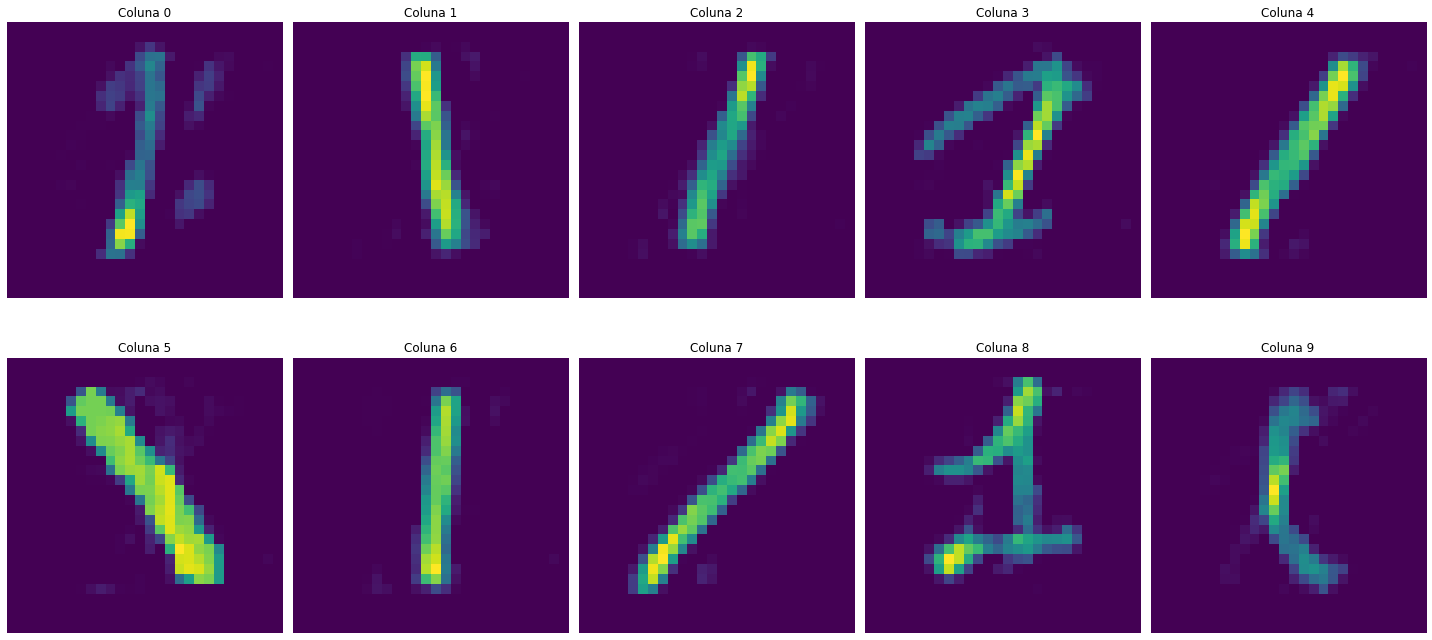

In [19]:
def display(dig, ndig, p, rows, cols):
    width=28
    height=28
    axes=[]
    fig=plt.figure(figsize=(20, 10))
    
    with open("dig_treino/W_{}_{}_{}.txt".format(dig,ndig,p)) as file:
        time = file.readline()
        Wd = np.loadtxt(file)

    for a in range(rows*cols):
        b = get_img(Wd[:, a: a + 1])
        axes.append( fig.add_subplot(rows, cols, a+1) )
        subplot_title=("Coluna "+str(a))
        axes[-1].set_title(subplot_title)
        plt.axis('off')  
        plt.imshow(b)
    fig.tight_layout()
    
    filename = 'treinos_W_{}_{}_{}.png'.format(dig, ndig, p)
    plt.savefig('figuras/{}'.format(filename), dpi=150)
display(1,100,10,2,5)

### <font color=#C81A38>Palpites e reconhecimento de dígitos</font>

Aqui, entende-se por palpite a atribuição de valor que se dá a uma matriz, em momento de identificar qual é o dígito representado, valendo-se das formas platônicas dos treinos $W_{d}$. Para tanto, tem-se em funcionamento `read_all_digits`, que lê do arquivo de texto os $W_{d}$, e a classe `PPTO`, que é um palpite orientado a objeto, isto é, para cada palpite enfeixa-se as informações do palpite propriamente dito, como o número de acertos, de erros e onde e como esses erros foram cometidos. Esses dados aparentemente excedentes são coletados de modo a incorporar a discussão da seção seguinte.

__Abre todos os treinos a partir dos arquivos de texto__

In [23]:
def read_all_digits(ndig_treino, p):
    all_dig = []
    for digito in range(10):
        filename = 'dig_treino/W_{}_{}_{}.txt'.format(digito, ndig_treino, p)
        with open(filename) as f:
            time = f.readline()
            Wd = np.loadtxt(f)
            all_dig.append(Wd)
    return all_dig

__Classe de todos os palpites e gerenciamento dos respectivos relatórios__

In [24]:
class PPTO:
    def __init__(self):
        # abrindo os arquivos
        with open('dados_mnist/test_images.txt') as f:
            self.A = np.loadtxt(f)
        with open('dados_mnist/test_index.txt') as f:
            self.asw = np.loadtxt(f, dtype=np.int8)
        
        # setando variáveis
        self.n, self.m = self.A.shape
        self.p = 0
        
        # vetores auxiliares
        self.D = np.zeros(self.m, dtype=np.int8)
        self.E = np.zeros(self.m)
        
        # todos os erros
        self.all_E = np.zeros((10, self.m))
        self.onde_errou = []

        # setando o contador
        self.count_dig = {}
        for digito in self.asw:
            sdigito = str(digito)
            if sdigito not in self.count_dig:
                self.count_dig[sdigito] = 1
            else:
                self.count_dig[sdigito] += 1

    def MMQS(self, Wds):
        self.n, self.p = Wds[0].shape # todos os 9 Wd's têm a mesma forma (shape)
        num_dig = len(Wds)
        for d in range(num_dig):
            # setando as variáveis
            Wd = Wds[d].copy()
            cpA = self.A.copy()
            
            # resolvendo o sistema simultâneo
            solve_multi(Wd, cpA, self.n, self.m, self.p)
            WH = np.dot(Wds[d], cpA[:self.p,:])
            C = np.subtract(self.A, WH)
            
            # calculando o erro de cada coluna
            for col in range(self.m):
                err = 0.0
                for row in range(self.n):
                    err += (C[row, col])**2
                err = math.sqrt(err)
                
                # coletando todos os erros
                self.all_E[d, col] = err
                
                # gerando os palpites
                if d == 0:
                    self.E[col] = err
                elif err < self.E[col]:
                    self.E[col] = err
                    self.D[col] = d
    
    def generate_report(self, ndig_treino):
        # inicializando o contador de acertos
        correct = 0
        correct_dig = {}
        
        for num in range(10):
            snum = str(num)
            correct_dig[snum] = 0
        
        # contando os acertos
        for row in range(self.m):
            if self.D[row] == self.asw[row]:
                correct += 1
                correct_dig[str(self.D[row])] += 1
            else:
                self.onde_errou.append(row)
            
        # gerando o relatório
        with open('reports/report_{}_{}.txt'.format(ndig_treino, self.p), 'w+') as f:
            f.write('Relatório do caso p = {} e ndig_treino = {}\n\n'.format(self.p, ndig_treino))
            f.write('Percentual total de acertos: {:.2f}%\n\n'.format((correct/self.m)*100))
            
            for dig, right in correct_dig.items():
                f.write('Digito ' + dig + '\n')
                total = self.count_dig[dig]
                f.write('Acertos: {}/{}\n'.format(right, total))
                f.write('Percentual de acertos: {:.2f}%\n\n'.format((right/total)*100))
        
        with open('erros/erros_{}_{}.txt'.format(ndig_treino, self.p), 'w+') as f:
            np.savetxt(f, self.all_E)
        with open('erros/onde_errou_{}_{}.txt'.format(ndig_treino, self.p), 'w+') as f:
            for item in self.onde_errou:
                f.write(str(item) + '\n')

__Gera todos os palpites e salva os relatórios de erros/acertos__

In [25]:
def palpite_all():
    ndig_treinos = [100, 1000, 4000]
    ps = [5, 10, 15]
    pp = PPTO()

    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Começo das classificações às {}\n".format(current_time))

    for ndig_treino in ndig_treinos:
        for p in ps:
            print('Caso ndig_treino {} com p {}\n'.format(ndig_treino, p))
            start = time.time()

            Wds = read_all_digits(ndig_treino, p)
            pp.MMQS(Wds)
            
            elapsed_time = (time.time() - start)
            print('Tempo gasto para o MMQ: {}\n'.format(elapsed_time))

            pp.generate_report(ndig_treino)
            # Resetando os valores
            pp.D = np.zeros(pp.m, dtype=np.int8)
            pp.E = np.zeros(pp.m)

            pp.all_E = np.zeros((10, pp.m))
            pp.onde_errou = []

    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print('Classificações concluídas às {}'.format(current_time))
palpite_all()

Começo das classificações às 17:56:11

Caso ndig_treino 100 com p 5

Tempo gasto para o MMQ: 196.68193697929382

Caso ndig_treino 100 com p 10

Tempo gasto para o MMQ: 227.0889446735382

Caso ndig_treino 100 com p 15

Tempo gasto para o MMQ: 271.9457354545593

Caso ndig_treino 1000 com p 5

Tempo gasto para o MMQ: 188.39534187316895

Caso ndig_treino 1000 com p 10

Tempo gasto para o MMQ: 194.64591360092163

Caso ndig_treino 1000 com p 15

Tempo gasto para o MMQ: 235.28224682807922

Caso ndig_treino 4000 com p 5

Tempo gasto para o MMQ: 186.109925031662

Caso ndig_treino 4000 com p 10

Tempo gasto para o MMQ: 205.74936437606812

Caso ndig_treino 4000 com p 15

Tempo gasto para o MMQ: 251.07306480407715

Classificações concluídas às 18:28:53


### <font color=#C81A38>Discussão qualitativa e quantitativa dos dados</font>

Inicialmente, a primeira pergunta que vem da execução de `palpite_all` é: deu certo? E, notadamente, a maneira mais direta de respondê-la é avaliando as taxas de acerto a depender da variação dos parâmetros. Para tanto, como `PPTO` já dá toda a informação necessária para tal pergunta, constrói-se o seguinte gráfico.

<img src="figuras/acerto_ndig_p.png" style="width:50%">

Algumas coisas saltam em um primeiro momento. De um modo geral, o desempenho é bem satisfatório, com todos os casos proporcionando pelo menos 85% de acerto. Outra coisa interessante é como os dados vão de acordo com o que esperado para a variação dos parâmetros: conforme aumentam $n_{dig}$ e $p$ também, de modo geral, aumentam as taxas de acerto. Isso porque não necessariamente isso se daria, posta a natureza do `NMF` (que inclui certas flutuações), que pode gerar certas imprecisões.<br>
De qualquer modo, apesar destes resultados, seria ainda interessante investigar como a taxa de acertos varia a depender do dígito. Acrescentando mais informações, a representação gráfica começa a ficar muito saturada e quiçá confusa, motivo pelo qual optou-se por representar uma passagem de casos de cada vez, entendendo por caso uma dada configuração dos parâmetros $n_{dig}$ e $p$. Simplesmente pelo motivo de que, nessa rodada, é a passagem com o maior degrau, a maior diferença relativa, será analisada a passagem do caso 100_10 ao 1000_10 (diferença de 2,63%).

<img src="figuras/acertos-100_10-1000_10.png" style="width:50%">

Agora, o resultado da análise materializada neste gráfico é mais interessante: o que poderia explicar essa distribuição? Porque 0 e 1 possuem a taxa tão maior? O que poderia explicar a variação de acertos do dígito 8?<br>
A hipótese que se propõe passa pela identidade de um dígito e sua resolução em um determinado caso, isto é, quão bem ele está caracterizado em $W_{d}$ e, consequentemente, quão bem será a aferência dele nos palpites que em este for o dígito correto. E uma questão importante é que, devido à metodologia aqui empregada, não é fundamental o erro quadrático da aproximação ser pequeno, mas sim ser o menor dentre as opções oferecidas pelos demais digitos. Isso leva a pensar que mais importante que pensar se $W_{d}$ é fidedigno é pensar quão distinguível ele é dos demais.<br>
E o que significa essa hipótese para este exemplo em específico? Tomando atenção ao 8 e sua forma, é justo crer que há uma maior semelhança deste com o 3, ou até com o 5, devido a suas curvas por vezes coincidentes, e a diferença de alguns poucos traços presentes ou ausentes.<br>
Observando os treinos $W_{8}$, $W_{3}$ e $W_{5}$:

<img src="figuras/treinos_W_8_100_10.png" style="width:50%">

<img src="figuras/treinos_W_3_100_10.png" style="width:50%">

<img src="figuras/treinos_W_5_100_10.png" style="width:50%">

Em certa conformidade com o que esperado, as formas são em alguma medida parecidas. Como mais um elemento de teste da hipótese, para esse caso, pode-se levar em conta ainda o fato de como o dígito 1 é diferente em forma destes últimos citados, como mostra a representação visualizável de $W_{1}$ abaixo:

<img src="figuras/treinos_W_1_100_10.png" style="width:50%">

Em suma: de acordo com a hipótese em avaliação espera-se que o que pode explicar a grande quantidade de erros para o dígito 8 no caso 100_10 é a má distinguibilidade deste dígito e sua confundibilidade com outros dígitos como o 5 ou o 3, mas certamente não com o 1. Quantitativamente falando, espera-se que, considerando apenas os erros de identificação do 8, haja uma grande quantidade de palpites para o 5 ou o 3, e poucos palpites para o 1.<br>
De modo a testar esta hipótese, fez-se uma análise de ranqueamento dos palpites errados. De maneira um pouco mais geral que o que proposto no documento de referência, a classe `PPTO` armazena não somente o melhor erro (o menor erro quadrático ao qual se associa o dígito correto a ser palpitado), mas também o "local do erro" (i.e., a qual dígito no gabarito fez-se um palpite errado) e o erro quadrático de todos os dígitos. Isso permite montar um ranking baseado em um dígito $d_{*}$: para todas as ocorrências de $d_{*}$ no gabarito, considera-se somente as vezes em que o palpite é um dígito $d_{k} \neq d_{*}$ (ou seja, um erro de palpite) e a frequência dos $d_{k}' \neq d_{k}'' \neq d_{k}''' \neq \dots$, (diferentes dígitos errados palpitados) é contada e disposta em um gráfico.<br>
<br>
Dispõe-se a seguir a análise ranquada dos erros de 8 para o caso 100_10:

<img src="figuras/top_3-digito_8-100_10.png" style="width:90%">

Primeiro buscando compreender estes resultados, vê-se que, quando se faz um palpite errado à identificação do dígito 8, os dígitos mais palpitados são os dígitos 5 e 9, que apareceram 50 vezes cada em primeiro lugar nestes palpites errados. Como era de se esperar ainda, o número de vezes em que o dígito 8 foi palpitado em um palpite errado é 0, uma vez que, sendo palpitado 8, então trata-se de um acerto, e não um erro, que é o que se está estudando agora.<br>
O comentário inicial e a consequente leitura do gráfico mostram que as derivações feitas a partir da hipótese inicial mostram-se adequadas: de fato, os dígitos 5 e 3 estão "bem colocados" no ranking de dígitos mal-palpitados, enquando dígitos como o 1 aparecem com menos frequência como o dígito chutado. Uma outra observação relevante que vem deste gráfico é a análise da segunda posição: o dígito 8 ganha com bastante vantagem sobre os demais. Isto é bem animador, da perpectiva da identidificação dos dígitos, pois significa que, mesmo quando se erra o palpite, quase sempre se tem o dígito correto como segunda opção.<br>
Algumas outras análises podem reiterar esse comportamento de 0 do dígito correto na 1ª posição de erro e prevalência do dígito correto na 2ª posição do erro:

<img src="figuras/top_3-digito_4-100_5.png" style="width:90%">

<img src="figuras/top_3-digito_9-4000_5.png" style="width:90%">

Como considerações finais, é interessante notar como este método, apesar de incluir alguma estocacidade, é bastante preciso e, quando não acerta, ao menos tinha a resposta certa como segunda opção na maioria dos casos, o que inegavelmente é uma informação animadora. O tratamento matricial das imagens e o artifício de decomposição em matrizes não-negativas mostrou-se, por um lado, palpável enquanto estratégia, crível enquanto abordagem, e, por outro, satisfatoriamente eficiente. Apesar da grande ajuda e esforço humanos, a máquina "conseguiu trabalhar" bem.

## <font color=#C8531A>Apêndice</font>

Os testes foram realizados executando os métodos em estudo em situações cujo resultado é previamente conhecido, seja porque fornecido no documento de referência, porque calculado manualmente e/ou no `Octave`, ou porque evidente. Em todo caso, tal conhecimento "a priori" é aqui disposto acima de cada célula de código do teste.

> Observação: os testes vêm como métodos `teste_X` em virtude do não-compartilhamento (perigoso) de variáveis cujo nome é comumente empregado em demais métodos (e.g., $W$, $A$ etc.).

### <font color=#C81A38>Teste dos métodos da Primeira Tarefa</font>

__Teste de `cos_sin`__

$W =
\begin{pmatrix}
1 & 2 \\
3 & 4
\end{pmatrix}$

$i = 1, j = 2, k = 1 \hspace{1cm} \left( w_{1,1} = 1 < 3 = w_{2,1} \right) \hspace{1cm} \tau = -\frac{w_{1,1}}{w_{2,1}} = -\frac{1}{3}\\
sin = \frac{1}{\sqrt{1 + \tau^{2}}} = \frac{1}{\sqrt{1 + (\frac{1}{3})^{2}}} \approx 0,9486833... \hspace{2cm} cos = \tau sin = - \frac{0,9486833}{3} \approx -0,31622777...$

In [26]:
def teste_cos_sin():
    W = np.array([[1.0,2.0], 
                  [3.0,4.0]])
    c, s = cos_sin(W, 1, 2, 1)
    print("cos =",c)
    print("sin =",s)
teste_cos_sin()

cos = -0.3162277660168379
sin = 0.9486832980505138


__Teste de `rot_Givens`__

Exemplo da página 2 do documento de referência.<br>
$Q(3,4,\theta) \cdot W = Q(3,4,\theta) \cdot
\begin{pmatrix}
2 & 1 & 1 & -1 & 1 \\
0 & 3 & 0 & 1 & 2 \\
0 & 0 & 2 & 2 & -1 \\
0 & 0 & -1 & 1 & 2 \\
0 & 0 & 0 & 3 & 1
\end{pmatrix} = 
\begin{pmatrix}
2 & 1 & 1 & -1 & 1 \\
0 & 3 & 0 & 1 & 2 \\
0 & 0 & \frac{5}{\sqrt{5}} & \frac{3}{\sqrt{5}} & -\frac{4}{\sqrt{5}} \\
0 & 0 & 0 & \frac{4}{\sqrt{5}} & \frac{3}{\sqrt{5}} \\
0 & 0 & 0 & 3 & 1
\end{pmatrix} \approx
\begin{pmatrix}
2 & 1 & 1 & -1 & 1 \\
0 & 3 & 0 & 1 & 2 \\
0 & 0 & 2,23606798 & 1,34164079 & -1,78885438 \\
0 & 0 & 0 & 1,78885438 & 1,34164079 \\
0 & 0 & 0 & 3 & 1
\end{pmatrix}$

In [ ]:
def teste_rot_Givens():
    A = np.array([[2.0, 1.0, 1.0,-1.0, 1.0],
                  [0.0, 3.0, 0.0, 1.0, 2.0],
                  [0.0, 0.0, 2.0, 2.0,-1.0],
                  [0.0, 0.0,-1.0, 1.0, 2.0],
                  [0.0, 0.0, 0.0, 3.0, 1.0]])

    cos, sin = cos_sin(A, 3, 4, 3)
    rot_Givens(A, 5, 5, 3, 4, cos, sin)
    print(A)
teste_rot_Givens()

__Teste de `solve`__

(comentar o lance das últimas linhas)

$W \cdot x = b \Rightarrow
\begin{pmatrix}
1 & 2 \\
3 & 4 \\
5 & 6
\end{pmatrix}
\cdot
\begin{pmatrix}
x_{1} \\
x_{2}
\end{pmatrix}
=
\begin{pmatrix}
1 \\
1 \\
1
\end{pmatrix} \Rightarrow
x = 
\begin{pmatrix}
-1 \\
1
\end{pmatrix}
$

In [ ]:
def teste_solve():
    W = np.array([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
    b = np.array([[1.0], [1.0], [1.0]])

    solve(W, b, 3, 2)
    print("x =\n",b[0:2,:])
teste_solve()

__Teste de `solve_multi`__

$W \cdot x = A \Rightarrow
\begin{pmatrix}
1 & 2 \\
2 & 1
\end{pmatrix}
\cdot
\begin{pmatrix}
x_{1,1} & x_{1,2} & x_{1,3} \\
x_{2,1} & x_{2,2} & x_{2,3}
\end{pmatrix}
=
\begin{pmatrix}
1 & 2 & 3 \\
4 & 5 & 6
\end{pmatrix} \Rightarrow
x = 
\begin{pmatrix}
\frac{7}{3} & \frac{8}{3} & 3 \\
-\frac{2}{3} & -\frac{1}{3} & 0
\end{pmatrix} \approx
\begin{pmatrix}
2,33333331 & 2,66666664 & 3 \\
-0,66666666 & -0,33333333 & 0
\end{pmatrix} 
$

In [ ]:
def teste_solve_multi():
    W = np.array([[1.0, 2.0], [2.0, 1.0]])
    A = np.array([[1.0,2.0,3.0],[4.0,5.0,6.0]])

    solve_multi(W, A, 2, 3, 2)
    print("x =\n",A)
teste_solve_multi()

### <font color=#C81A38>Teste dos métodos da Segunda Tarefa</font>

__Teste de `erro`__

Exemplo da página 6 do documento de referência (decomposição exata).<br>
$E = \| A - WH  \|^2 = 0$, para <br><br>
$A =
\begin{pmatrix}
\frac{3}{10} & \frac{3}{5} & 0 \\
\frac{1}{2} & 0 & 1 \\
\frac{4}{10} & \frac{4}{5} & 0
\end{pmatrix}, \quad W =
\begin{pmatrix}
\frac{3}{5} & 0 \\
0 & 1 \\
\frac{4}{5} & 0
\end{pmatrix}, \quad H =
\begin{pmatrix}
\frac{1}{2} & 1 & 0 \\
\frac{1}{2} & 0 & 1
\end{pmatrix}$

In [ ]:
def teste_erro():
    A = np.array([[0.3,0.6,0.0],[0.5,0.0,1.0],[0.4,0.8,0.0]])
    W = np.array([[0.6,0.0],[0.0,1.0],[0.8,0.0]])
    H = np.array([[0.5,1.0,0.0],[0.5,0.0,1.0]])
    E = erro(A,W,H,3,3)
    print("E =", E)
teste_erro()

__Teste de `norm`__

Pela definição de normalização, <br>
$normalização \left[ \begin{pmatrix}
1 & 2 & 3 \\
4 & 5 & 6 \\
7 & 8 & 9
\end{pmatrix} \right] = 
\begin{pmatrix}
\frac{1}{\sqrt{66}} & \frac{2}{\sqrt{93}} & \frac{3}{\sqrt{126}} \\
\frac{4}{\sqrt{66}} & \frac{5}{\sqrt{93}} & \frac{6}{\sqrt{126}} \\
\frac{7}{\sqrt{66}} & \frac{8}{\sqrt{93}} & \frac{9}{\sqrt{126}}
\end{pmatrix} \approx
\begin{pmatrix}
0,12309149 & 0,20739034 & 0,26726124 \\
0,49236596 & 0,51847585 & 0,53452248 \\
0,86164043 & 0,82956136 & 0,80178372
\end{pmatrix}$

In [ ]:
def teste_norm():
    W = np.array([[1.0,2.0,3.0],[4.0,5.0,6.0],[7.0,8.0,9.0]])
    A = norm(W,3,3)
    print("norm(W) =\n",A)
teste_norm()

__Teste de `set_matrix`__

Pela definição deste tipo de matriz (página 5 do documento de referência),<br><br>
$redefinição\left(2,4\right) \left[ \begin{pmatrix}
-1 & 2 & -3 & 4 \\
5 & -6 & 7 & -8 \\
9 & 10 & 11 & 12 \\
13 & 14 & 15 & 16
\end{pmatrix} \right] = 
\begin{pmatrix}
0 & 2 & 0 & 4 \\
5 & 0 & 7 & 0
\end{pmatrix}
$

In [ ]:
def teste_set_matrix():
    A = np.array([[-1.0,2.0,-3.0,4.0],[5.0,-6.0,7.0,-8.0],[9.0,10.0,11.0,12.0],[13.0,14.0,15.0,16.0]])
    B = set_matrix(A,2,4)
    print("B =\n",B)
teste_set_matrix()

__Teste de `NMF`__

Exemplo da página 6 do documento de referência (decomposição exata).
> Observação: Neste caso, em que $\epsilon = 10^{-5}$, a resposta não é exata. Testes aqui omitidos foram feitos com precisão bem maior $\left(\epsilon = 10^{-40} \right)$ e por meio destes obteve-se resultado exato indicado no documento. Isto comprova a eficiência do algoritmo.<br>
Não é de interesse, porém, esse nível de precisão, uma vez que grande parte das matrizes com as quais `NMF` lidará sequer possuem decomposição exata. É por este motivo que o resultado apresentado (assim como todos os demais calculados por este método) tem $\epsilon = 10^{-5}$.

$A = W \cdot H \Rightarrow
\begin{pmatrix}
\frac{3}{10} & \frac{3}{5} & 0 \\
\frac{1}{2} & 0 & 1 \\
\frac{4}{10} & \frac{4}{5} & 0
\end{pmatrix} =
\begin{pmatrix}
\frac{3}{5} & 0 \\
0 & 1 \\
\frac{4}{5} & 0 \\
\end{pmatrix} \cdot
\begin{pmatrix}
\frac{1}{2} & 1 & 0 \\
\frac{1}{2} & 0 & 1
\end{pmatrix} \Rightarrow
W =
\begin{pmatrix}
0,6 & 0 \\
0 & 1 \\
0,8 & 0 \\
\end{pmatrix}, \quad
H =
\begin{pmatrix}
0,5 & 1 & 0 \\
0,5 & 0 & 1
\end{pmatrix}$

In [ ]:
def teste_NMF():
    A = np.array([[0.3,0.6,0.0],[0.5,0.0,1.0],[0.4,0.8,0.0]])
    n = 3
    m = 3
    p = 2
    W, H = NMF(A, n, m, p)
    print("W =\n",W)
    print("H =\n",H)
teste_NMF()

### <font color=#C81A38>Verificação dos resultados pelo Octave dos Testes Sugeridos</font>

Para os __Testes Sugeridos__ da Primeira Tarefa, foi conveniente calcular o que pedido também pelo `Octave`, de modo a poder comparar os resultados. Os resultados destes testes seguem-se a seguir: 

__teste A__<br>
octave:17> inv(W)*b<br>
ans =<br>

    0.492308
    0.015385
    0.476923
    0.030769
    0.461538
    0.046154
    0.446154
    0.061538
    0.430769
    0.076923
    0.415385
    0.092308
    0.400000
    0.107692
    0.384615
    0.123077
    0.369231
    0.138462
    0.353846
    0.153846
    0.338462
    0.169231
    0.323077
    0.184615
    0.307692
    0.200000
    0.292308
    0.215385
    0.276923
    0.230769
    0.261538
    0.246154
    0.246154
    0.261538
    0.230769
    0.276923
    0.215385
    0.292308
    0.200000
    0.307692
    0.184615
    0.323077
    0.169231
    0.338462
    0.153846
    0.353846
    0.138462
    0.369231
    0.123077
    0.384615
    0.107692
    0.400000
    0.092308
    0.415385
    0.076923
    0.430769
    0.061538
    0.446154
    0.046154
    0.461538
    0.030769
    0.476923
    0.015385
    0.492308

__teste B__<br>
octave:6> x = linsolve(W,b)<br>
x =<br>

    56.358
    -45.875
    -43.489
    -48.577
    -30.140
    89.812
    48.714
    59.239
    11.446
    109.163
    -72.873
    -54.363
    -51.444
    -25.015
    98.572
    218.659
    298.400

__teste C__<br>
octave:14> inv(W)*A<br>
ans =<br>

     0   -32   -64
     1     1     2
     1    34    68
     0     2     4
     0   -30   -60
     1     3     6
     1    36    72
     0     4     8
     0   -28   -56
     1     5    10
     1    38    76
     0     6    12
     0   -26   -52
     1     7    14
     1    40    80
     0     8    16
     0   -24   -48
     1     9    18
     1    42    84
     0    10    20
     0   -22   -44
     1    11    22
     1    44    88
     0    12    24
     0   -20   -40
     1    13    26
     1    46    92
     0    14    28
     0   -18   -36
     1    15    30
     1    48    96
     0    16    32
     0   -16   -32
     1    17    34
     1    50   100
     0    18    36
     0   -14   -28
     1    19    38
     1    52   104
     0    20    40
     0   -12   -24
     1    21    42
     1    54   108
     0    22    44
     0   -10   -20
     1    23    46
     1    56   112
     0    24    48
     0    -8   -16
     1    25    50
     1    58   116
     0    26    52
     0    -6   -12
     1    27    54
     1    60   120
     0    28    56
     0    -4    -8
     1    29    58
     1    62   124
     0    30    60
     0    -2    -4
     1    31    62
     1    64   128
     0    32    64
     
__teste D__<br>
octave:9> x = linsolve (W,A)<br>
x =<br>

     2.88155    56.35781   112.71562
    -1.83376   -45.87485   -91.74970
    -1.51399   -43.48902   -86.97805
    -1.52191   -48.57655   -97.15310
    -0.45379   -30.14020   -60.28040
     5.85670    89.81212   179.62424
     3.42193    48.71365    97.42730
     3.65656    59.23925   118.47849
     1.20368    11.44636    22.89271
     6.12534   109.16274   218.32547
    -2.47971   -72.87275  -145.74551
    -1.47793   -54.36289  -108.72579
    -1.20390   -51.44442  -102.88883
     0.12841   -25.01481   -50.02963
     6.50159    98.57194   197.14388
    11.49106   218.65886   437.31772
    14.58053   298.40023   596.80046


### <font color=#C81A38>Geração de gráficos para a análise dos resultados</font>

In [31]:
def get_data():
    data = [[],[],[]]
    ndig = [100, 1000, 4000]
    ps = [5, 10, 15]

    for x in range(len(ps)):
        for y in range(len(ndig)):
            report = "reports/report_{}_{}.txt".format(ndig[y], ps[x])
            with open(report, "r") as f:
                    lines = f.readlines()
                    data[y].append(float(lines[2][-7:-2]))

    return data[0], data[1], data[2]

In [32]:
def get_data1(ndig, p):
    report = "reports/report_{}_{}.txt".format(ndig, p)
    
    with open(report, "r") as f:
        lines = f.read().replace('\n', ' ')
        matched = re.findall('[0-9]+\.[0-9]+', lines)
        matched = matched[1:]
        for index in range(len(matched)):
            matched[index] = float(matched[index])
        return matched

In [33]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

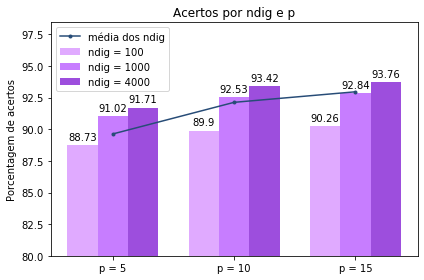

In [34]:
def data_mean(data):
    y = []

    for p in data:
        y.append((p[0] + p[1] + p[2])/3)
    return y

labels = ['p = 5','p = 10','p = 15']
data1, data2, data3 = get_data()

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
y = data_mean([data1, data2, data3])

mean = ax.plot([0,1,2], y,'.-', color='#274c77', label="média dos ndig")

rects1 = ax.bar(x - width, data1, width, label='ndig = 100', fc='#e0aaff')
rects2 = ax.bar(x, data2, width, label='ndig = 1000', fc='#c77dff')
rects3 = ax.bar(x + width, data3, width, label='ndig = 4000', fc='#9d4edd')

ax.set_ylabel('Porcentagem de acertos')
ax.set_title('Acertos por ndig e p')
ax.set_ylim(ymin=80)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc=2)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.savefig('figuras/acerto_ndig_p.png', dpi=150)
plt.show()

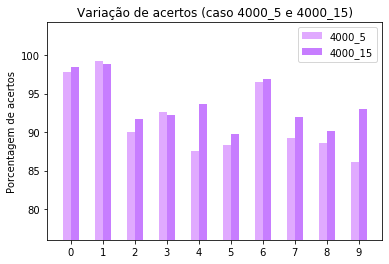

In [40]:
def compare_casos(ndig1, p1, ndig2, p2):
    fig1, ax1 = plt.subplots()

    caso1 = get_data1(ndig1,p1)
    caso2 = get_data1(ndig2,p2)

    labels = ['0','1','2','3','4','5','6','7','8','9']
    x = np.arange(len(labels))  # the label locations
    width = 0.25

    rects1 = ax1.bar(x - width/2, caso1, width, label='{}_{}'.format(ndig1,p1), fc='#e0aaff')
    rects2 = ax1.bar(x + width/2, caso2, width, label='{}_{}'.format(ndig2,p2), fc='#c77dff')

    ax1.set_ylabel('Porcentagem de acertos')
    ax1.set_title('Variação de acertos (caso {}_{} e {}_{})'.format(ndig1, p1, ndig2, p2))
    ax1.set_ylim(ymin=76)
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels)

    ax1.legend(loc=1)
    plt.savefig('figuras/acertos-{}_{}-{}_{}.png'.format(ndig1, p1, ndig2, p2), dpi=150)
    plt.show()
compare_casos(4000, 5, 4000, 15)

In [36]:
# depende dos erros e do onde errou
def get_k_rank(k, ndig, p, digito):
    # inicializa o dicionário
    topk_digitos = {}
    for i in range(1, k+1):
        topk_digitos[i] = {}
        
    with open('dados_mnist/test_index.txt') as f:
        asw = np.loadtxt(f, dtype=np.int8)
    
    erros = np.loadtxt('erros/erros_{}_{}.txt'.format(ndig, p))
    
    with open('erros/onde_errou_{}_{}.txt'.format(ndig, p), "r") as f:
        # iterando pelos erros
        for pos in f.readlines():
            pos = int(pos)
            d = asw[pos]
            #print(pos)
            if d == digito: # apenas olho para o digito escolhido
                erro_d = {}
                #print(pos)
                for val in range(10):
                    erro_d[erros[val, pos]] = val    
                erro_d = sorted(erro_d.items()) # ordena os erros
                #print(str(d) + '\n' + str(erro_d))
                for i in range(0, k):
                    dl = erro_d[i][1]
                    #print(dl)
                    if dl not in topk_digitos[i + 1]: # inicializa os valores
                        topk_digitos[i + 1][dl] = 1
                    else:
                        topk_digitos[i + 1][dl] += 1 # faz o update
                #print('----')
        return topk_digitos

In [37]:
def autolabel_deluxe(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [38]:
def plot_top_k(topks, k, ndig, p, digito, preset):
    labels = ['0','1','2','3','4','5','6','7','8','9']
    
    fig, ax = plt.subplots(preset[0], preset[1], figsize=(13,6)) 
    fig.subplots_adjust(bottom=0.1, top=0.88)
    fig.suptitle('Histogramas do top {} digitos chutados no lugar do {} - caso {}_{}'.format(k, digito, ndig, p), size=15, y=1.05)
    
    for i in range(k):
        rect = ax[i].bar(list(topks[i + 1].keys()), topks[i + 1].values(), width=0.5, color='#c77dff')
        autolabel_deluxe(rect, ax[i])
        ax[i].set_title('{}º posição'.format(i + 1), size=14)
        
        ax[i].set_ylabel('Frequência', size=14)
        x = np.arange(len(labels))  # the label locations
        ax[i].set_xticks(x)
        ax[i].set_xticklabels(labels)
        
    plt.savefig('figuras/top_{}-digito_{}-{}_{}.png'.format(k, digito, ndig, p), dpi=150)
    plt.show()

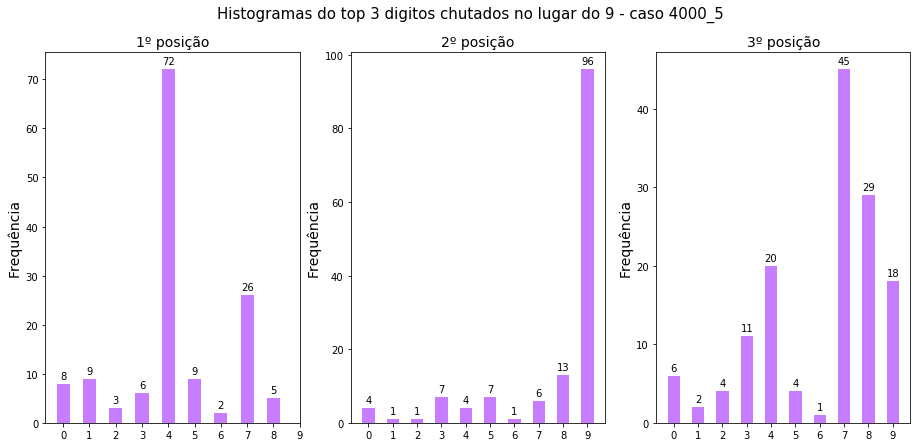

In [41]:
def create_top_plots(k=3, ndig=4000, p=5, digito=9, preset=(1,3)): # preset define como dispor as imagens (depende de k)
    topks = get_k_rank(k,ndig,p,digito)
    plot_top_k(topks,k,ndig,p,digito,preset)
create_top_plots()